In [1]:
from prophet import Prophet

%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import reduce

In [ ]:
# KServer.apvi....

# class Model(Sklearn, Tensor, torch....):
#     def __init__():
#         self...
#         self.weights = random_initialize()

#     def fit(self, X, y):
#         self.weights.update()
#         return self

#     def predict(self, X):
#         return self.f(X)...

    #   def transofrm(self, X):
    #     return self.predict(X)

    #  def fit_predict():
    #      return self.fit().predict(X)


In [63]:
file_path = "./data_files/time_series_analysis/rossmann_train.csv"
sales = pd.read_csv(file_path, low_memory = False)

# function composition
def compose(*args):
    def compose_two(f, g):
        return lambda x: g(f(x))
    return reduce(compose_two, args)

# convert to date function(closure form)
def convert_to_date(date_col):
    def _convert(df):
        df[date_col] = pd.to_datetime(df[date_col])
        return df
    return _convert

# set index function (closure form)
def set_date_index(date_col):
    def _set_date_index(df):
        df.index = df[date_col]
        return df
    return _set_date_index

# choose store function (closure form)
def choose_store(store_id):
    def _choose(df):
        return df[df['Store'] == store_id]
    return _choose

def filter_open_days(df):
    return df[df['Open'] == 1].copy()

def plot_sales(df):
    df['Sales'].plot(figsize = (25,5))
    plt.grid(linestyle = '--')
    plt.title("Store 1 sales plot")
    plt.ylabel("Sales")
    plt.show()

def make_simple_prophet_data(ds = 'Date', y = 'Sales'):
    def _make_simple_prophet_data(df):
        df = df.copy()
        df['ds'] = df[ds]
        df['y'] = df[y]
        return df[['ds', 'y']].copy()
    return _make_simple_prophet_data

In [3]:
cleaning_pipeline = compose(
    convert_to_date("Date"), 
    set_date_index("Date"))

store1_pipeline = compose(
    cleaning_pipeline, 
    choose_store(1))

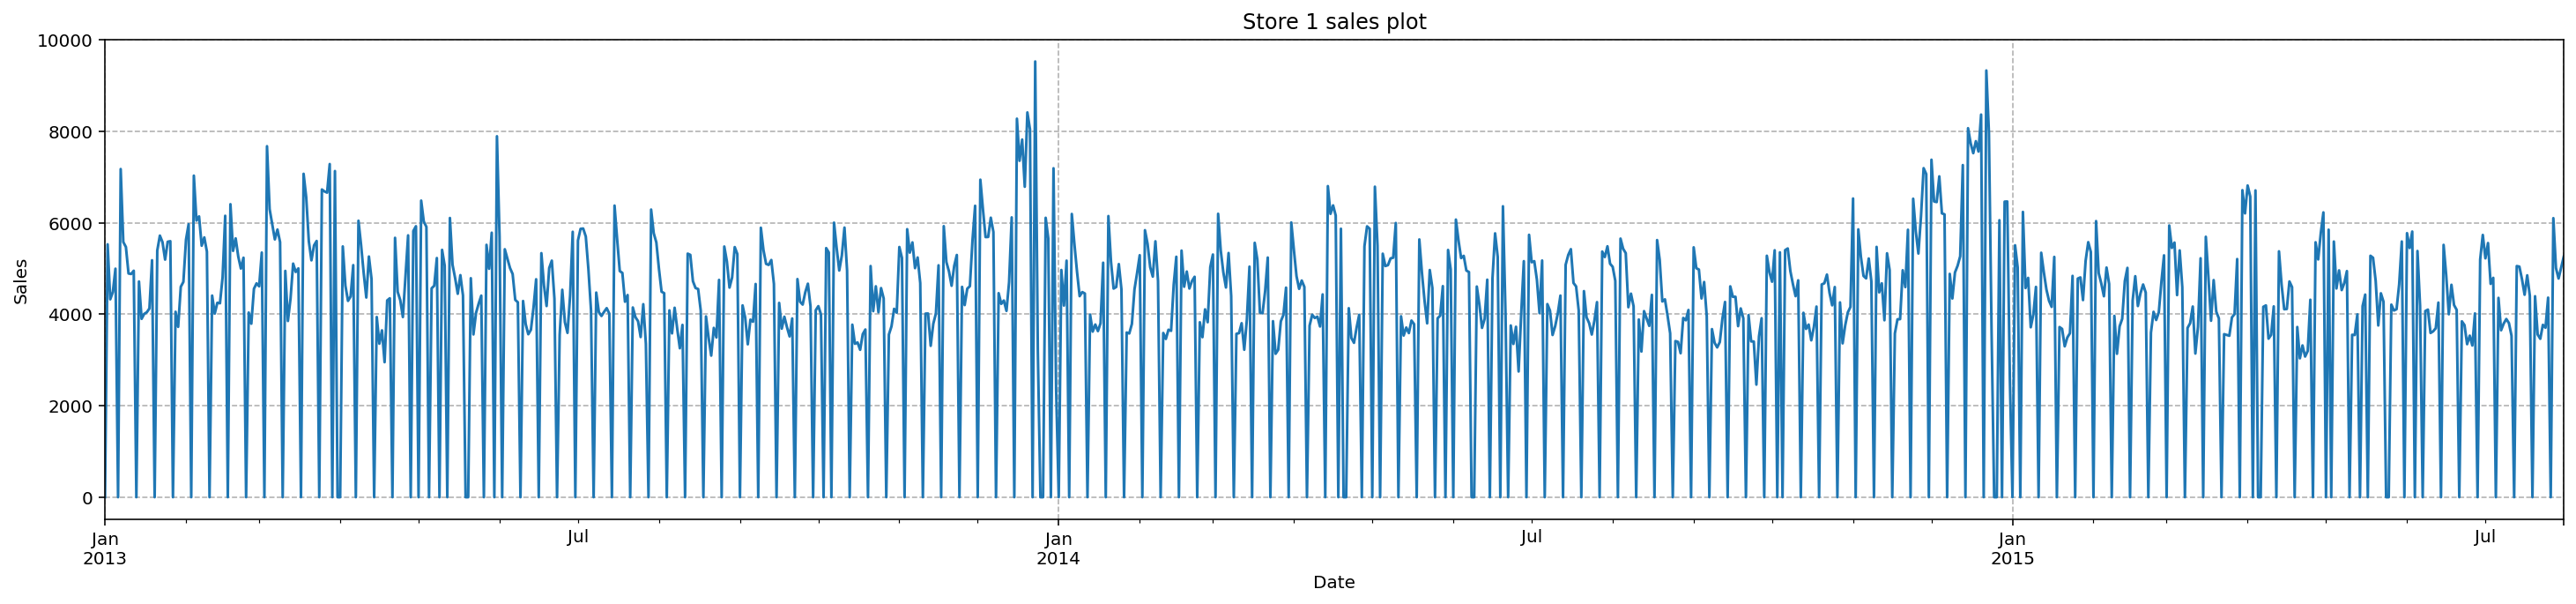

In [4]:
plot_sales(store1_pipeline(sales))

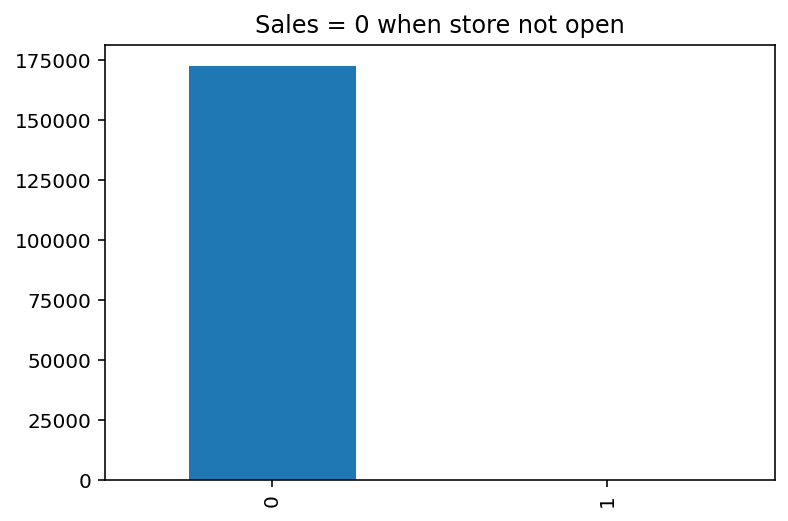

In [5]:
sales[sales.Sales == 0].Open.value_counts().plot(kind = 'bar')
plt.title("Sales = 0 when store not open")
plt.show()

In [6]:
open_store1 = compose(store1_pipeline, filter_open_days)

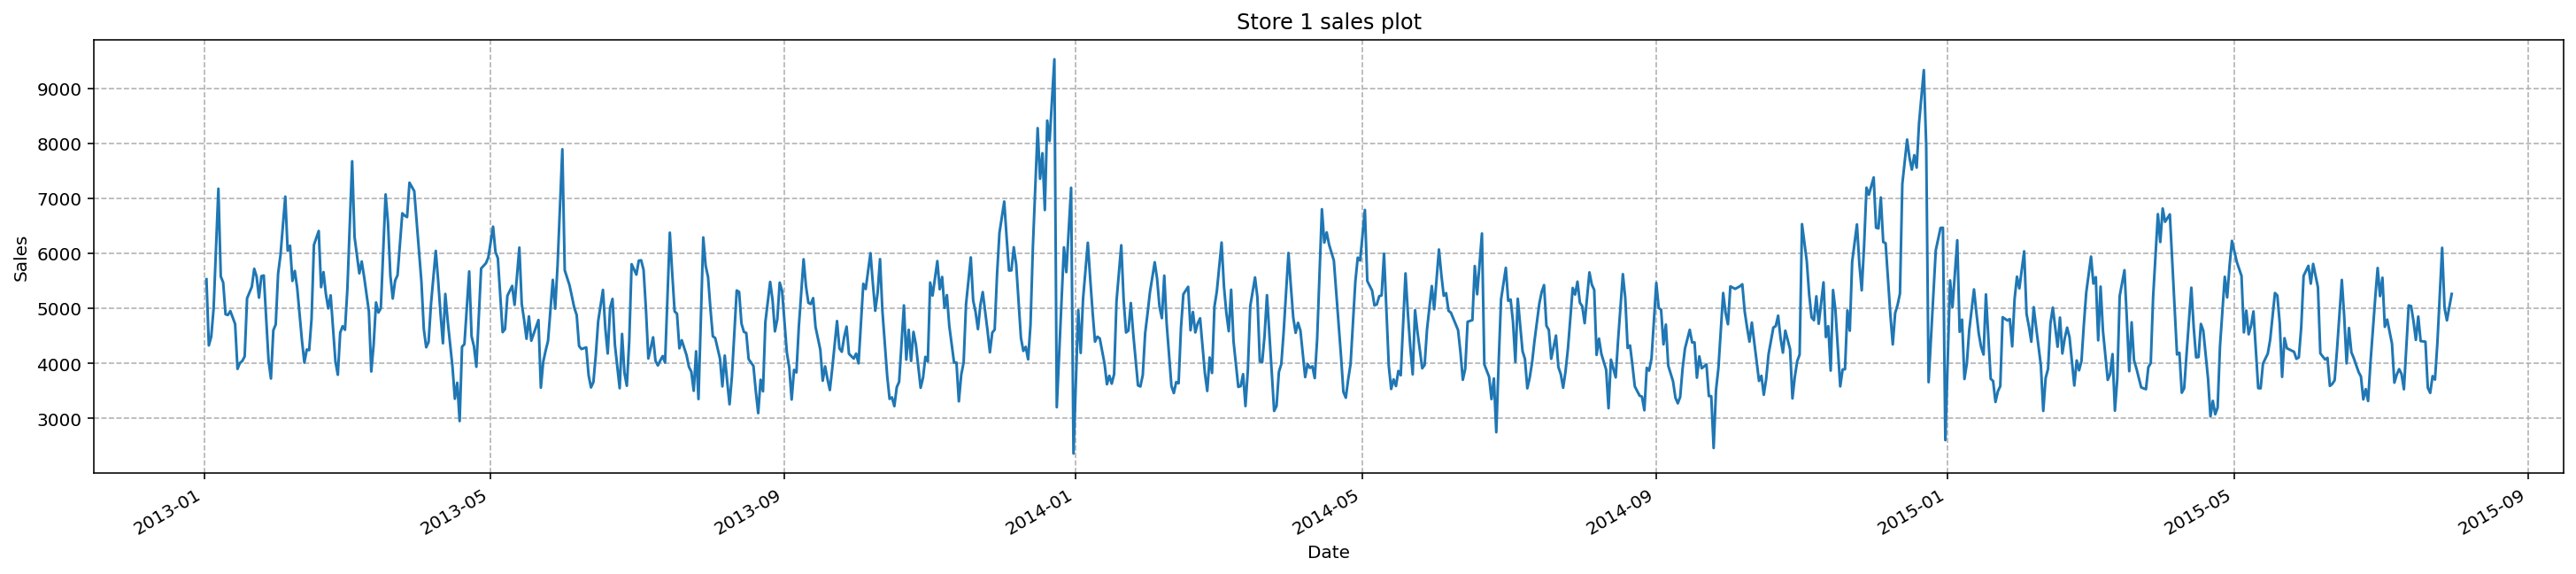

In [7]:
plot_sales(open_store1(sales))

In [8]:
prophet_pipeline = compose(
    store1_pipeline, 
    make_simple_prophet_data()
)

In [9]:
m = Prophet()
m.fit(prophet_pipeline(sales))
future = m.make_future_dataframe(periods = 365)
forecast = m.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -45.6372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1542.85    0.00719059        167.77      0.5469           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       1544.06   1.68931e-05       83.4267   1.796e-07       0.001      267  LS failed, Hessian reset 
     197       1544.06   4.65361e-08       79.3941     0.08172           1      299   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


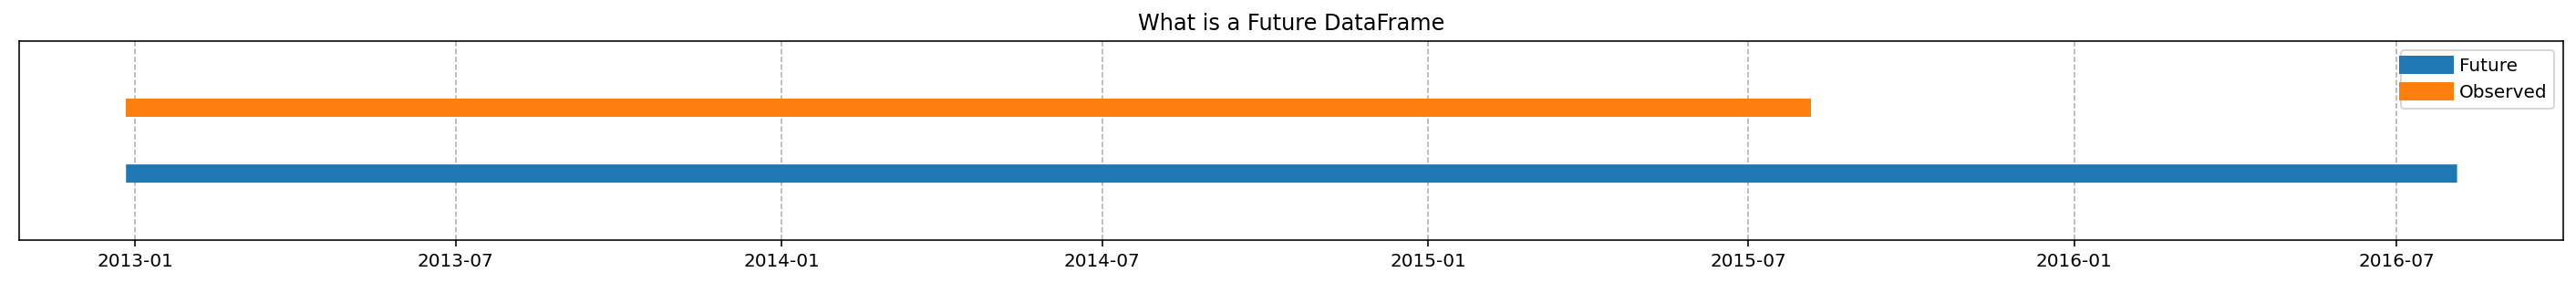

In [10]:
fig, ax = plt.subplots(figsize = (25,2))
plt.plot(future['ds'], np.ones(len(future)), lw = 10, label = 'Future')
plt.plot(
    store1_pipeline(sales)['Date'], 
    2 * np.ones(store1_pipeline(sales).shape[0]), lw = 10, label = 'Observed')

plt.ylim(0,3)
plt.yticks([])
plt.grid(linestyle = '--')
plt.legend(loc = 'upper right')
plt.title("What is a Future DataFrame", fontsize = 12)
plt.show()

**A future dataframe contains past & future**

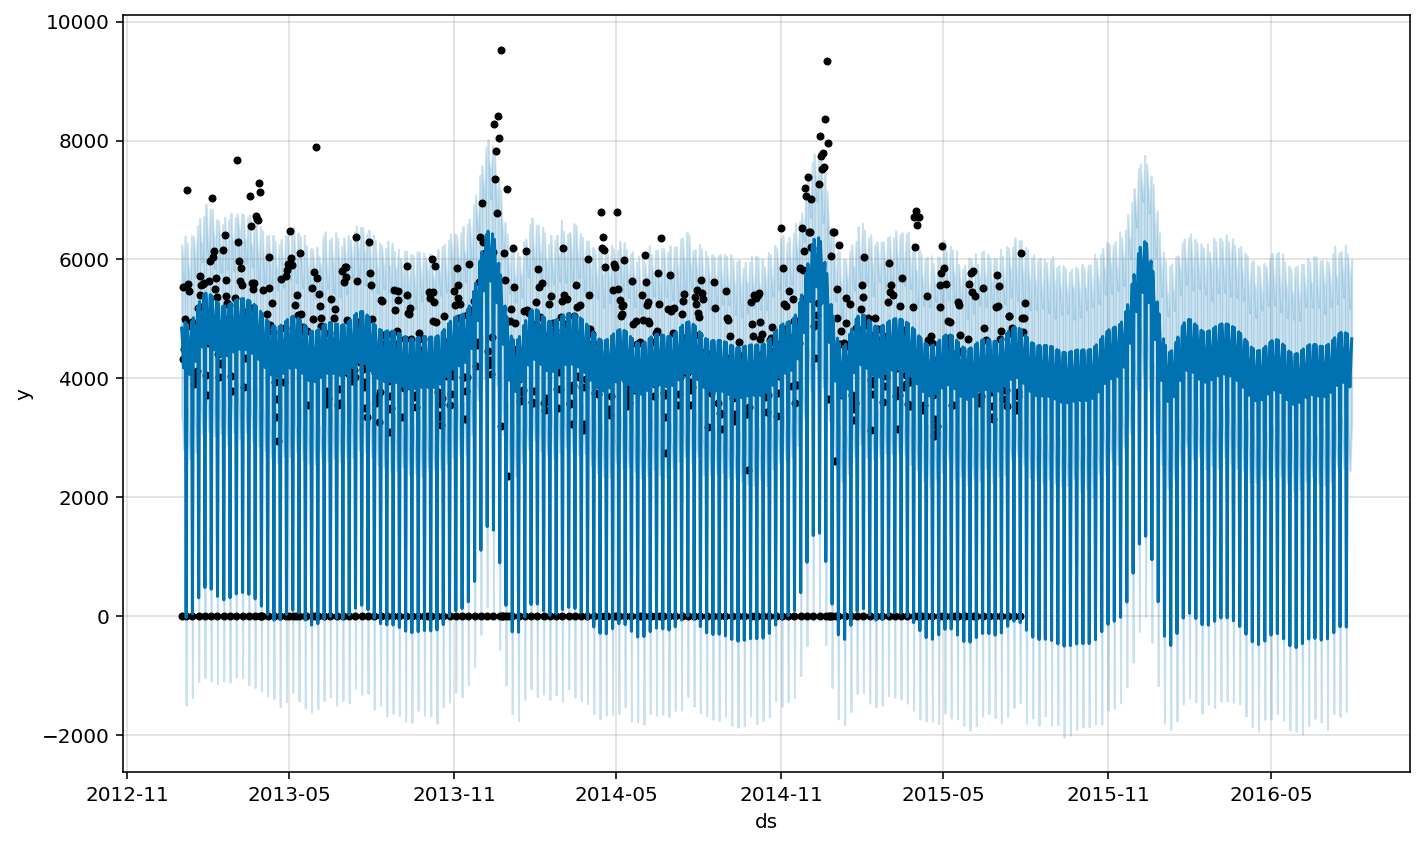

In [11]:
m.plot(forecast)
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


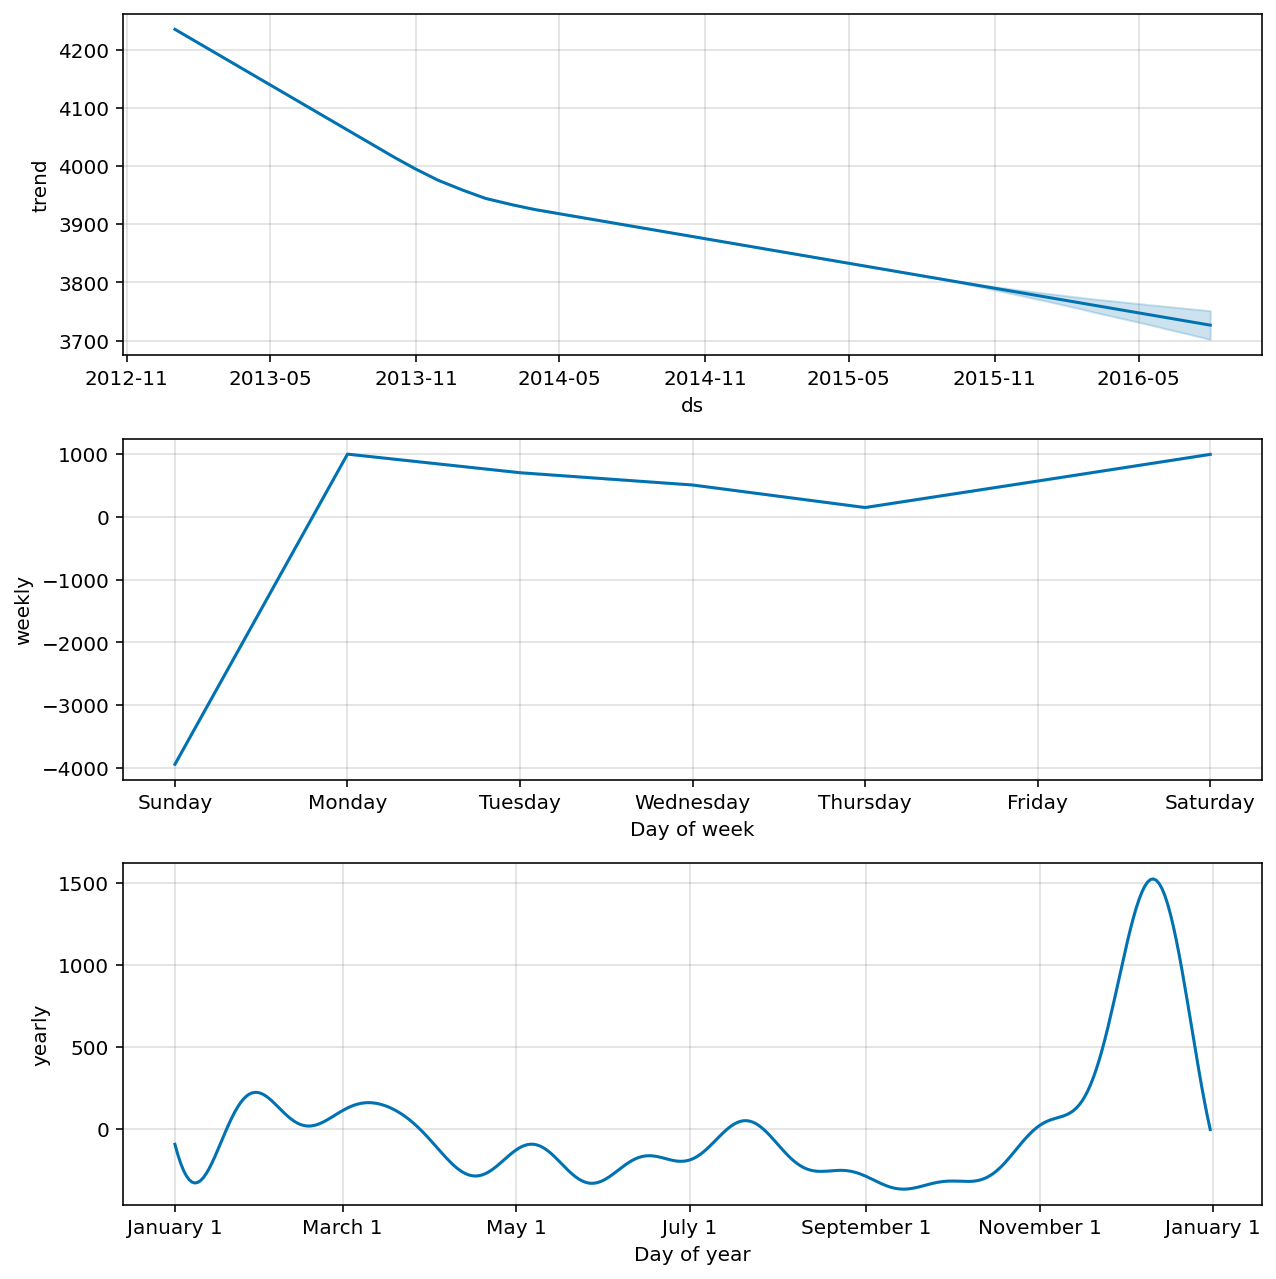

In [12]:
m.plot_components(forecast)
plt.show()

In [13]:
class PipelinedModel:
    
    def __init__(self, pipeline, model = None, test_periods = 365, multivariate = False):
        self.pipeline = pipeline
        self.model = model if model else Prophet()
        self.test_periods = test_periods
        self.multivariate = multivariate

    def make_train(self, data):
        if self.multivariate:
            self.train = self.pipeline(data).sort_index()[:-self.test_periods]
        else:
            self.train = self.pipeline(data)

        print(self.train.ds.min(), self.train.ds.max())
        return self.train

    def make_future(self, data = None, periods = None):
        if self.multivariate:
            self.future =  self.pipeline(data).drop('y', axis = 1).sort_index()
        else:
            periods = periods if periods else self.test_periods
            self.future = self.model.make_future_dataframe(periods = periods)
        return self.future

    def fit(self, data):
        self.model.fit(self.make_train(data))
        self.make_future(data)
        return self
    
    def forecast(self, periods = None):
        periods = periods if periods else self.test_periods
        future = self.future
        return self.model.predict(future)

    def plot(self, periods = None):
        periods = periods if periods else self.test_periods
        return self.model.plot(self.forecast(periods))

    def plot_components(self, periods = None):
        periods = periods if periods else self.test_periods
        return self.model.plot_components(self.forecast(periods))

In [14]:
pm1 = PipelinedModel(prophet_pipeline).fit(sales)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2013-01-01 00:00:00 2015-07-31 00:00:00
Initial log joint probability = -45.6372


/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1542.85    0.00719059        167.77      0.5469           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       1544.06   1.68931e-05       83.4267   1.796e-07       0.001      267  LS failed, Hessian reset 
     197       1544.06   4.65361e-08       79.3941     0.08172           1      299   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


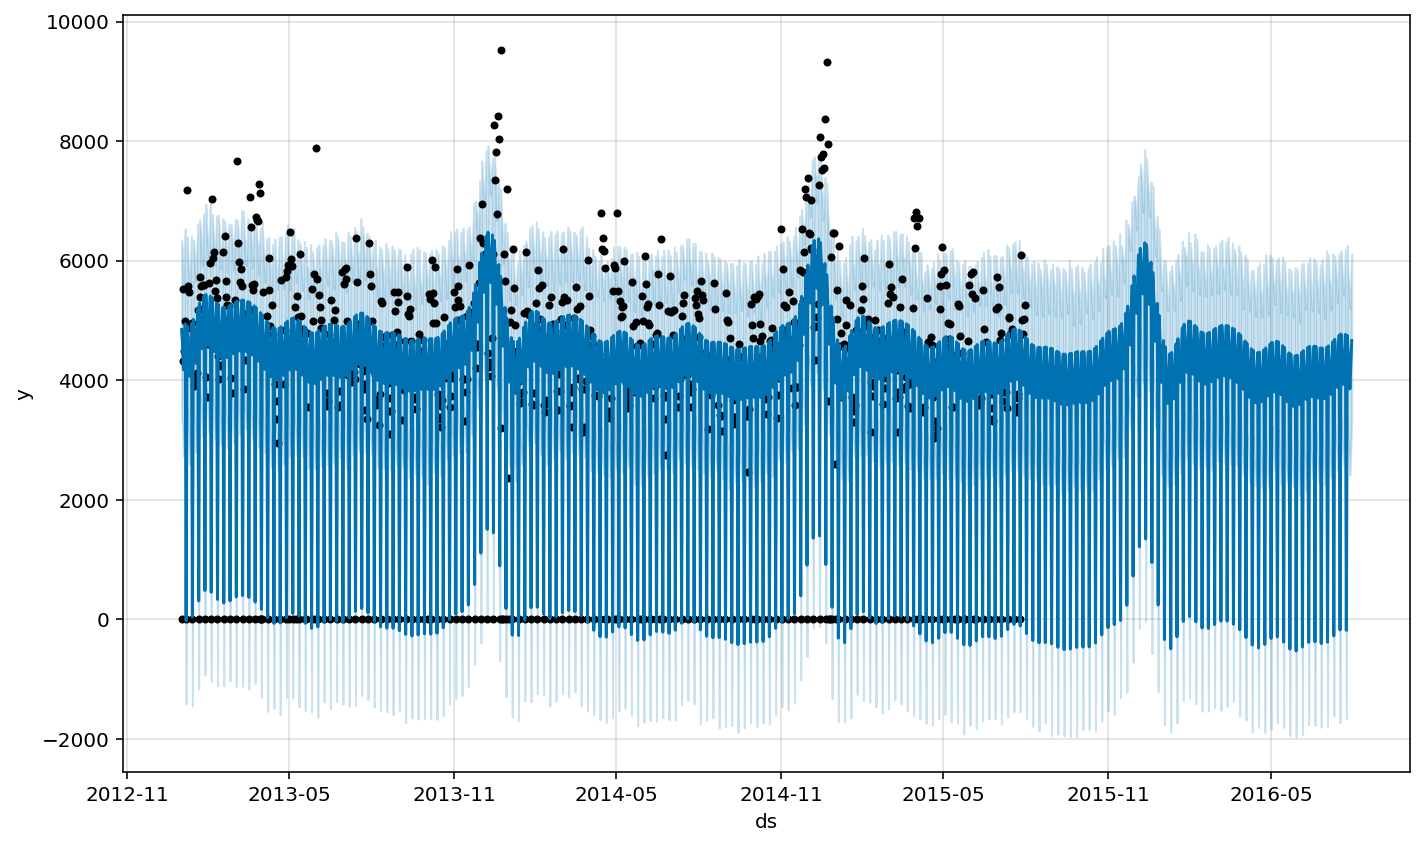

In [16]:
pm1.plot()
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


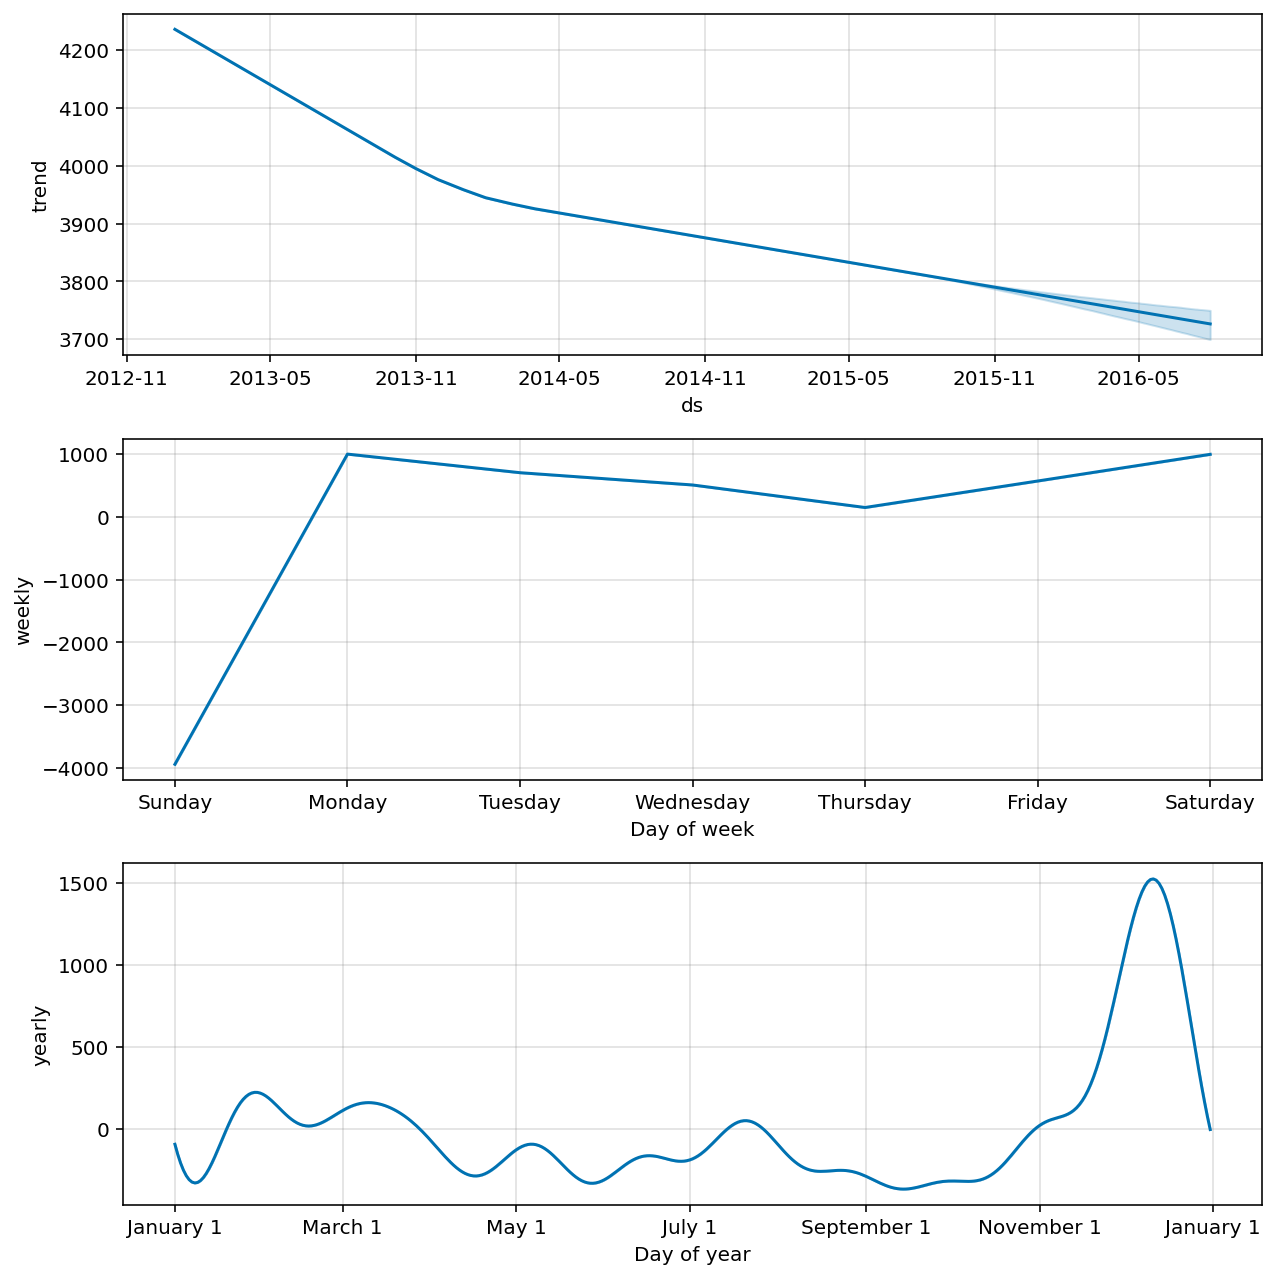

In [17]:
pm1.plot_components()
plt.show()

In [18]:
prophet_clean_pipeline = compose(
    store1_pipeline, 
    filter_open_days, 
    make_simple_prophet_data()
)

In [19]:
pm2 = PipelinedModel(prophet_clean_pipeline).fit(sales)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2013-01-02 00:00:00 2015-07-31 00:00:00
Initial log joint probability = -8.10439


/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1496.8   4.15395e-06       81.6028           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123        1496.8   2.30717e-08       65.4622       0.132      0.3458      164   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


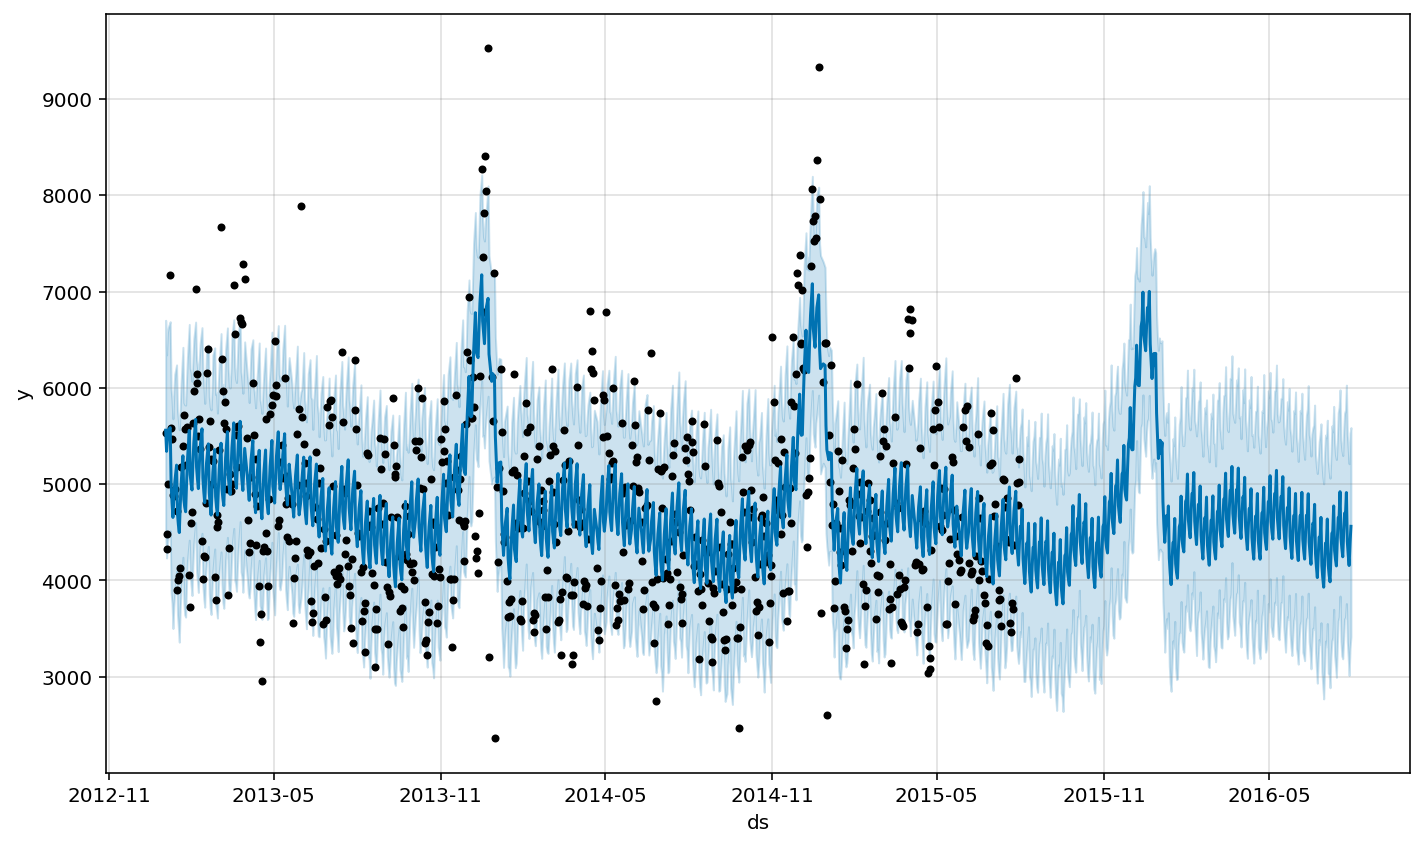

In [20]:
pm2.plot()
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


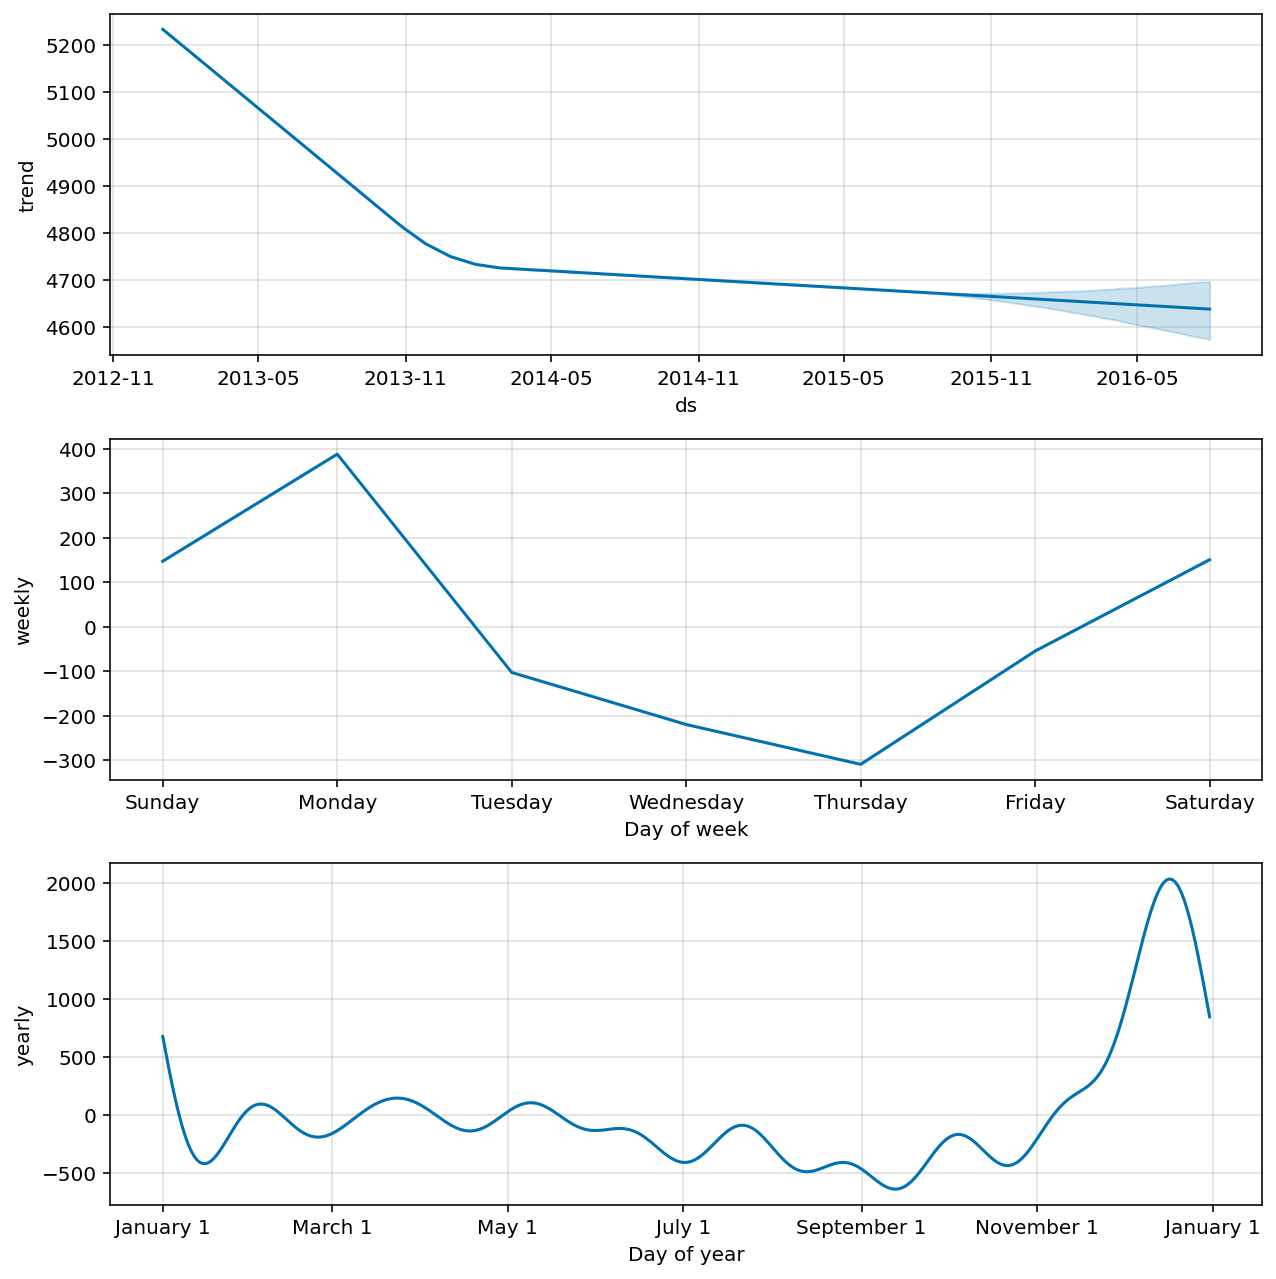

In [21]:
pm2.plot_components()
plt.show()

In [22]:
tmp_model =  Prophet()
tmp_model.add_country_holidays(country_name = "US")

pm3 = PipelinedModel(prophet_clean_pipeline, tmp_model).fit(sales)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2013-01-02 00:00:00 2015-07-31 00:00:00


/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -8.10439
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       1500.47   2.95817e-05       82.2963       0.535       0.535      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       1500.47   9.24344e-05       72.5389   1.009e-06       0.001      196  LS failed, Hessian reset 
     176       1500.48   2.18945e-06       88.2885   3.749e-08       0.001      303  LS failed, Hessian reset 
     190       1500.48   6.48874e-08       71.4278      0.2177           1      319   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


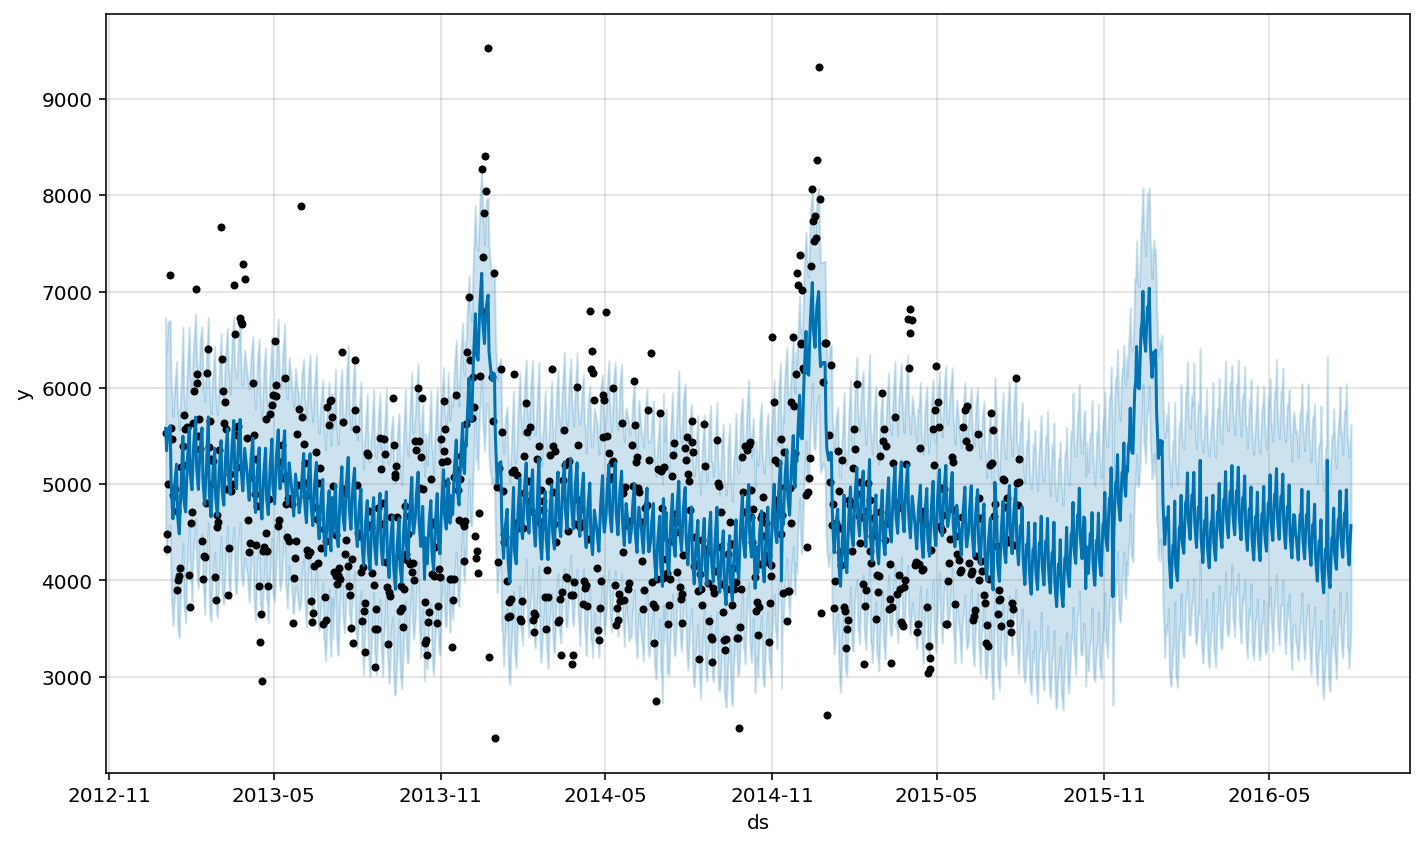

In [23]:
pm3.plot()
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


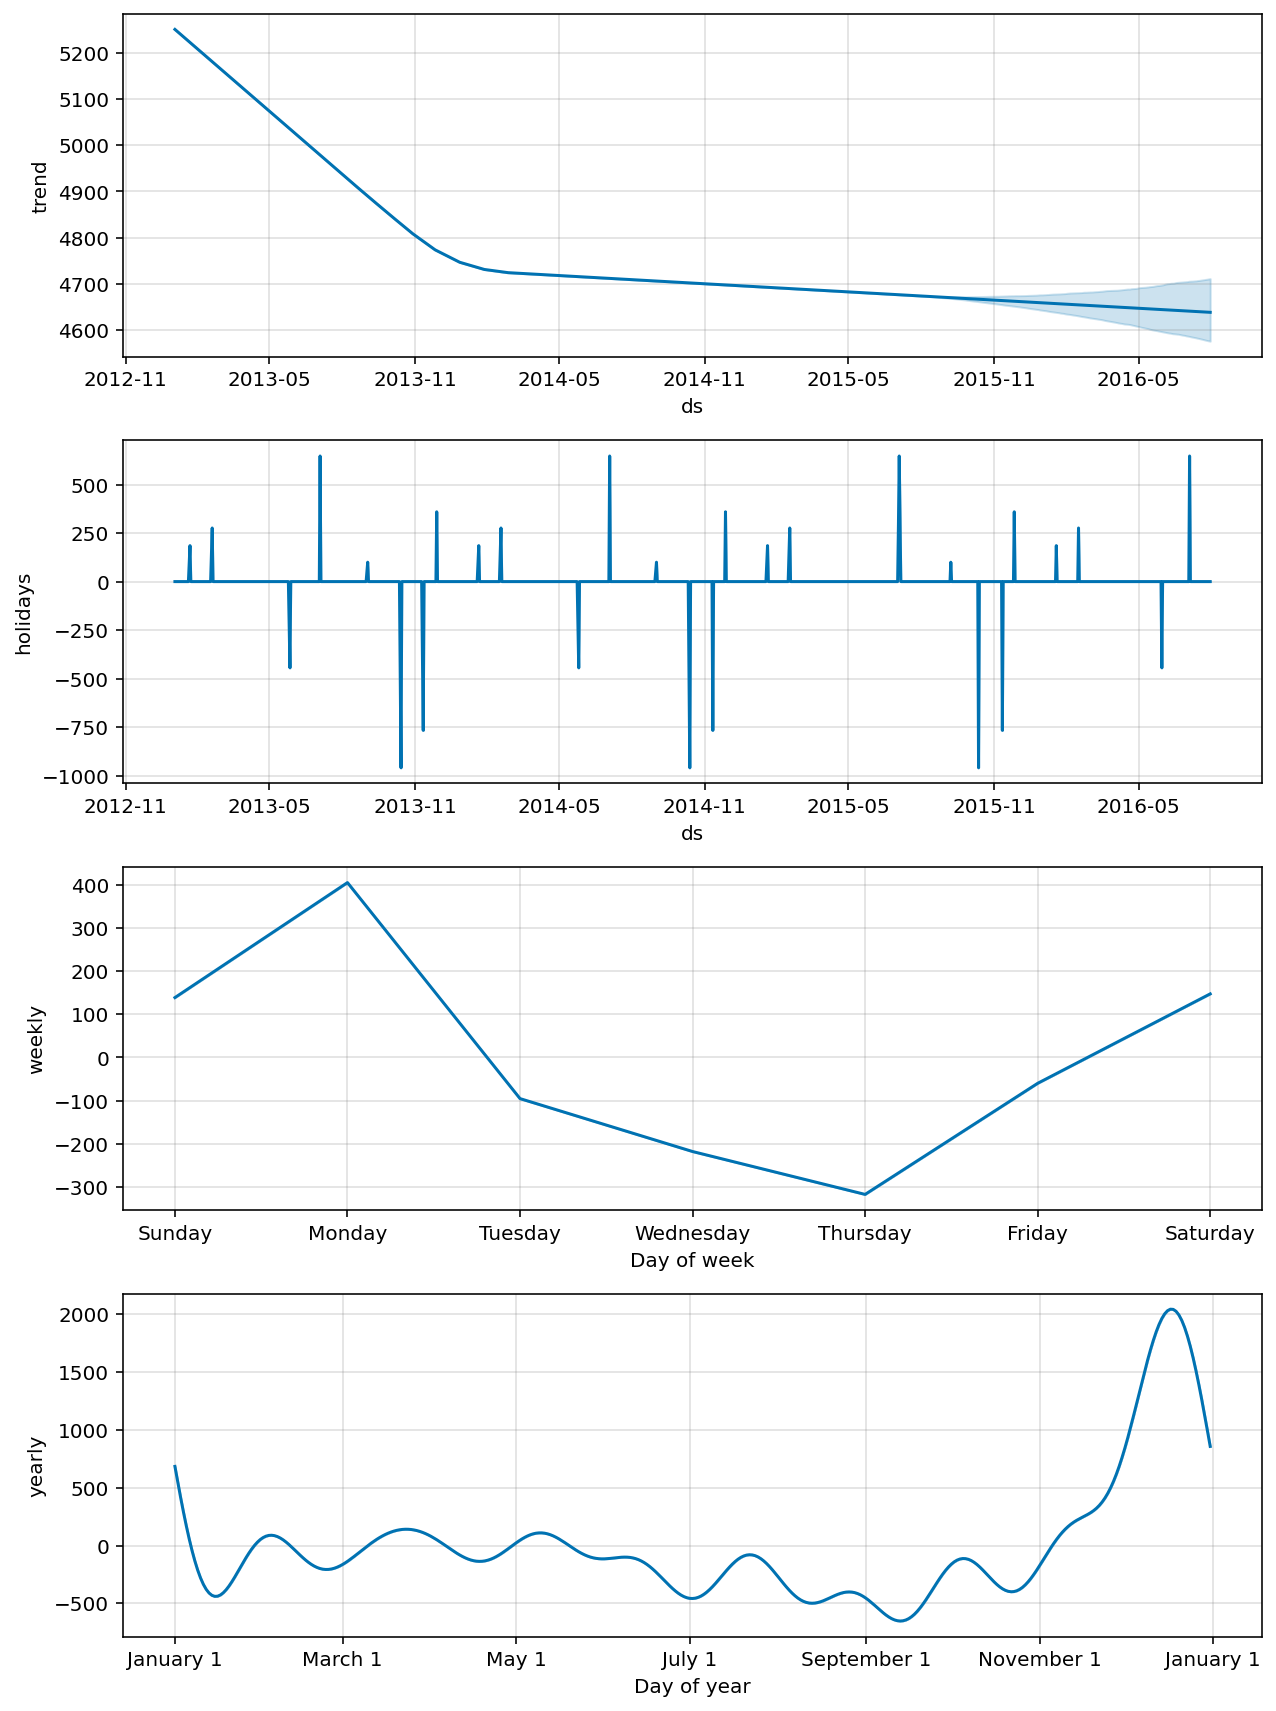

In [24]:
pm3.plot_components()
plt.show()

In [25]:
sales.head()

Store  DayOfWeek       Date  Sales  Customers  Open  Promo  \
Date                                                                     
2015-07-31      1          5 2015-07-31   5263        555     1      1   
2015-07-31      2          5 2015-07-31   6064        625     1      1   
2015-07-31      3          5 2015-07-31   8314        821     1      1   
2015-07-31      4          5 2015-07-31  13995       1498     1      1   
2015-07-31      5          5 2015-07-31   4822        559     1      1   

           StateHoliday  SchoolHoliday  
Date                                    
2015-07-31            0              1  
2015-07-31            0              1  
2015-07-31            0              1  
2015-07-31            0              1  
2015-07-31            0              1

### Variable Inpect

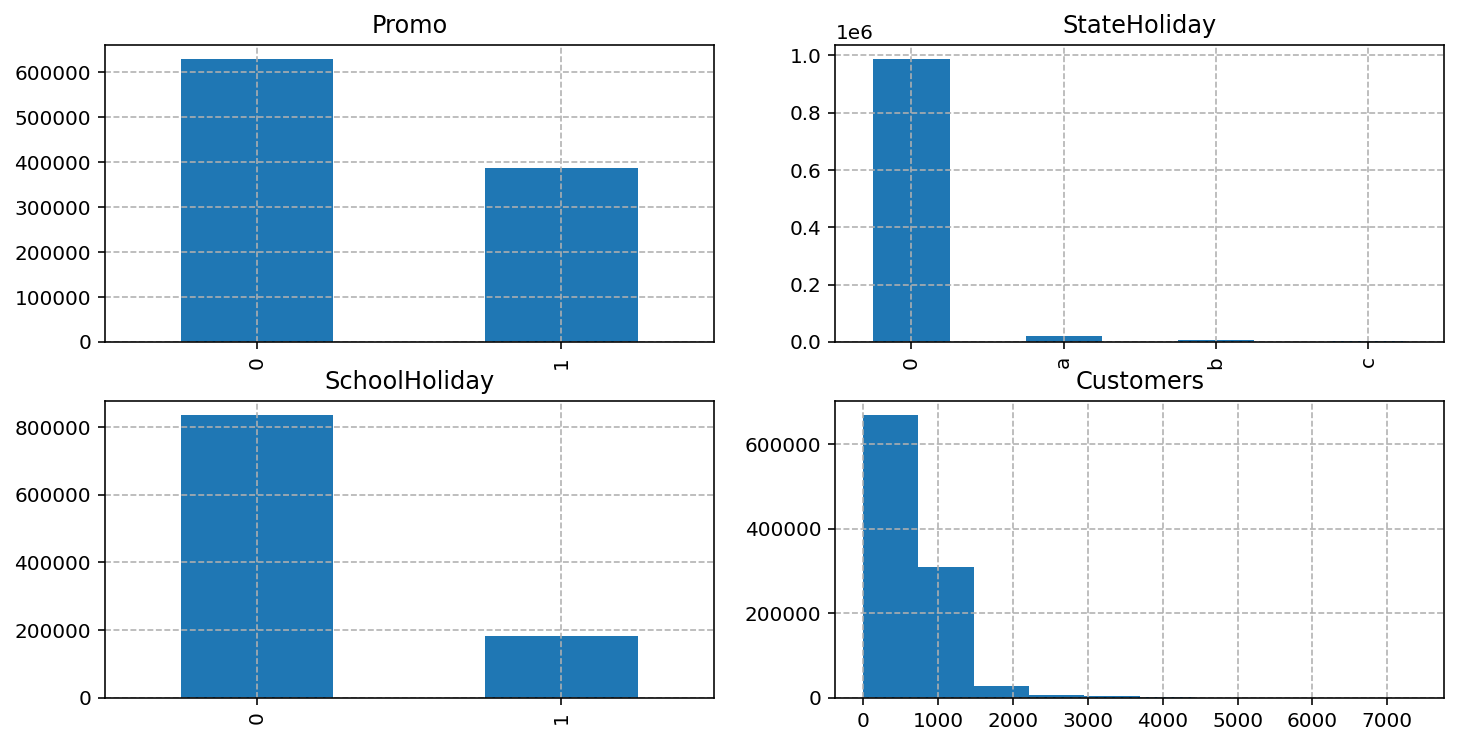

In [26]:
fig, ax = plt.subplots(figsize = (12,6))
plt.subplot(2,2,1)
sales['Promo'].value_counts().plot(kind = 'bar')
plt.title("Promo")
plt.grid(linestyle = '--')
plt.subplot(2,2,2)
sales['StateHoliday'].value_counts().plot(kind = 'bar')
plt.title("StateHoliday")
plt.grid(linestyle = '--')
plt.subplot(2,2,3)
sales['SchoolHoliday'].value_counts().plot(kind = 'bar')
plt.title("SchoolHoliday")
plt.grid(linestyle = '--')
plt.subplot(2,2,4)
sales['Customers'].hist()
plt.title("Customers")
plt.grid(linestyle = '--')
plt.show()

In [27]:
def feature_engineering(df):
    df = df.copy()
    df[['SH1','SH2', 'SH3']] = pd.get_dummies(df['StateHoliday'], drop_first = True).copy()
    return df

def feed_to_prophet_multivariable(ds = 'Date', y = 'Sales', columns = None):
    if columns is None:
        columns = ['ds','y','Promo','SH1','SH2','SH3','SchoolHoliday']
    def _feed_to_prophet_multivariable(df):
        df.rename(columns = {ds:"ds", y:"y"}, inplace = True)
        return df[columns]
    return _feed_to_prophet_multivariable

In [28]:
full_pipeline = compose(
    store1_pipeline, 
    feature_engineering, 
    feed_to_prophet_multivariable('Date', 'Sales', ['ds','y','Promo','SH1','SH2','SH3','SchoolHoliday',"Open"])
    )

def create_model():
    tmpmodel = Prophet()
    tmpmodel.add_regressor('Open', mode = 'multiplicative')
    tmpmodel.add_regressor('Promo', mode = 'additive')
    tmpmodel.add_regressor('SH1', mode = 'additive')
    tmpmodel.add_regressor('SH2', mode = 'additive')
    tmpmodel.add_regressor('SH3', mode = 'additive')
    tmpmodel.add_regressor('SchoolHoliday', mode = 'additive')
    return tmpmodel

pm4 = PipelinedModel(
    full_pipeline, 
    create_model(), 
    test_periods = 365,
    multivariate=True)

pm4.fit(sales)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2013-01-01 00:00:00 2014-07-31 00:00:00


/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -29.6789
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1255.9     0.0294902       195.013           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1263.23   0.000965757       122.675           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       1263.88   0.000176304       104.097    1.59e-06       0.001      324  LS failed, Hessian reset 
     299       1264.41    0.00115716       82.2401           1           1      397   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     303        1264.5   0.000721204       119.111   8.458e-06       0.001      441  LS failed, Hessian reset 
     399        1265.1    0.00594722       90.8996           1           1      570   
    Iter      log pro

/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/l

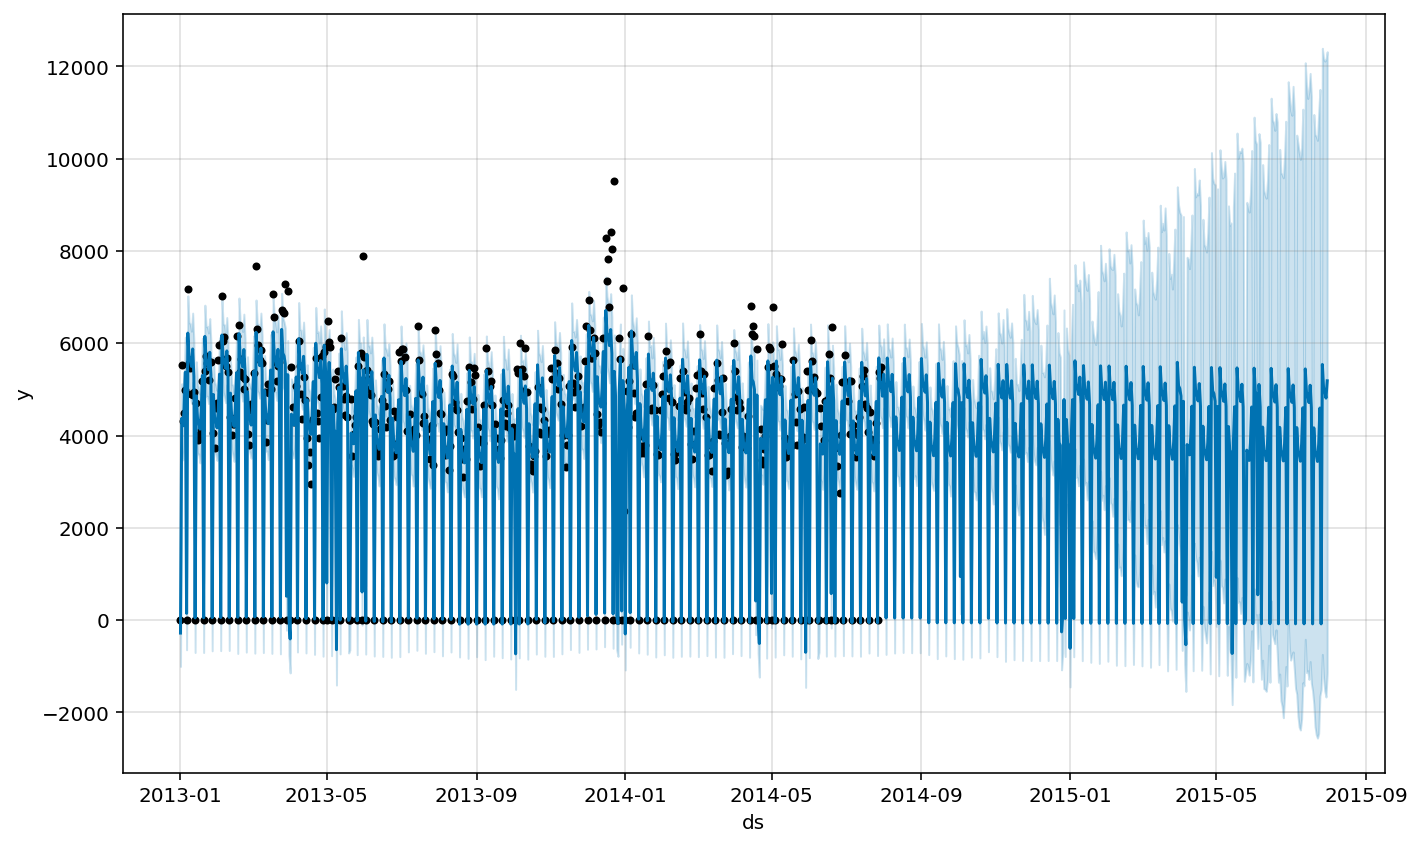

In [29]:
pm4.plot()
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/l

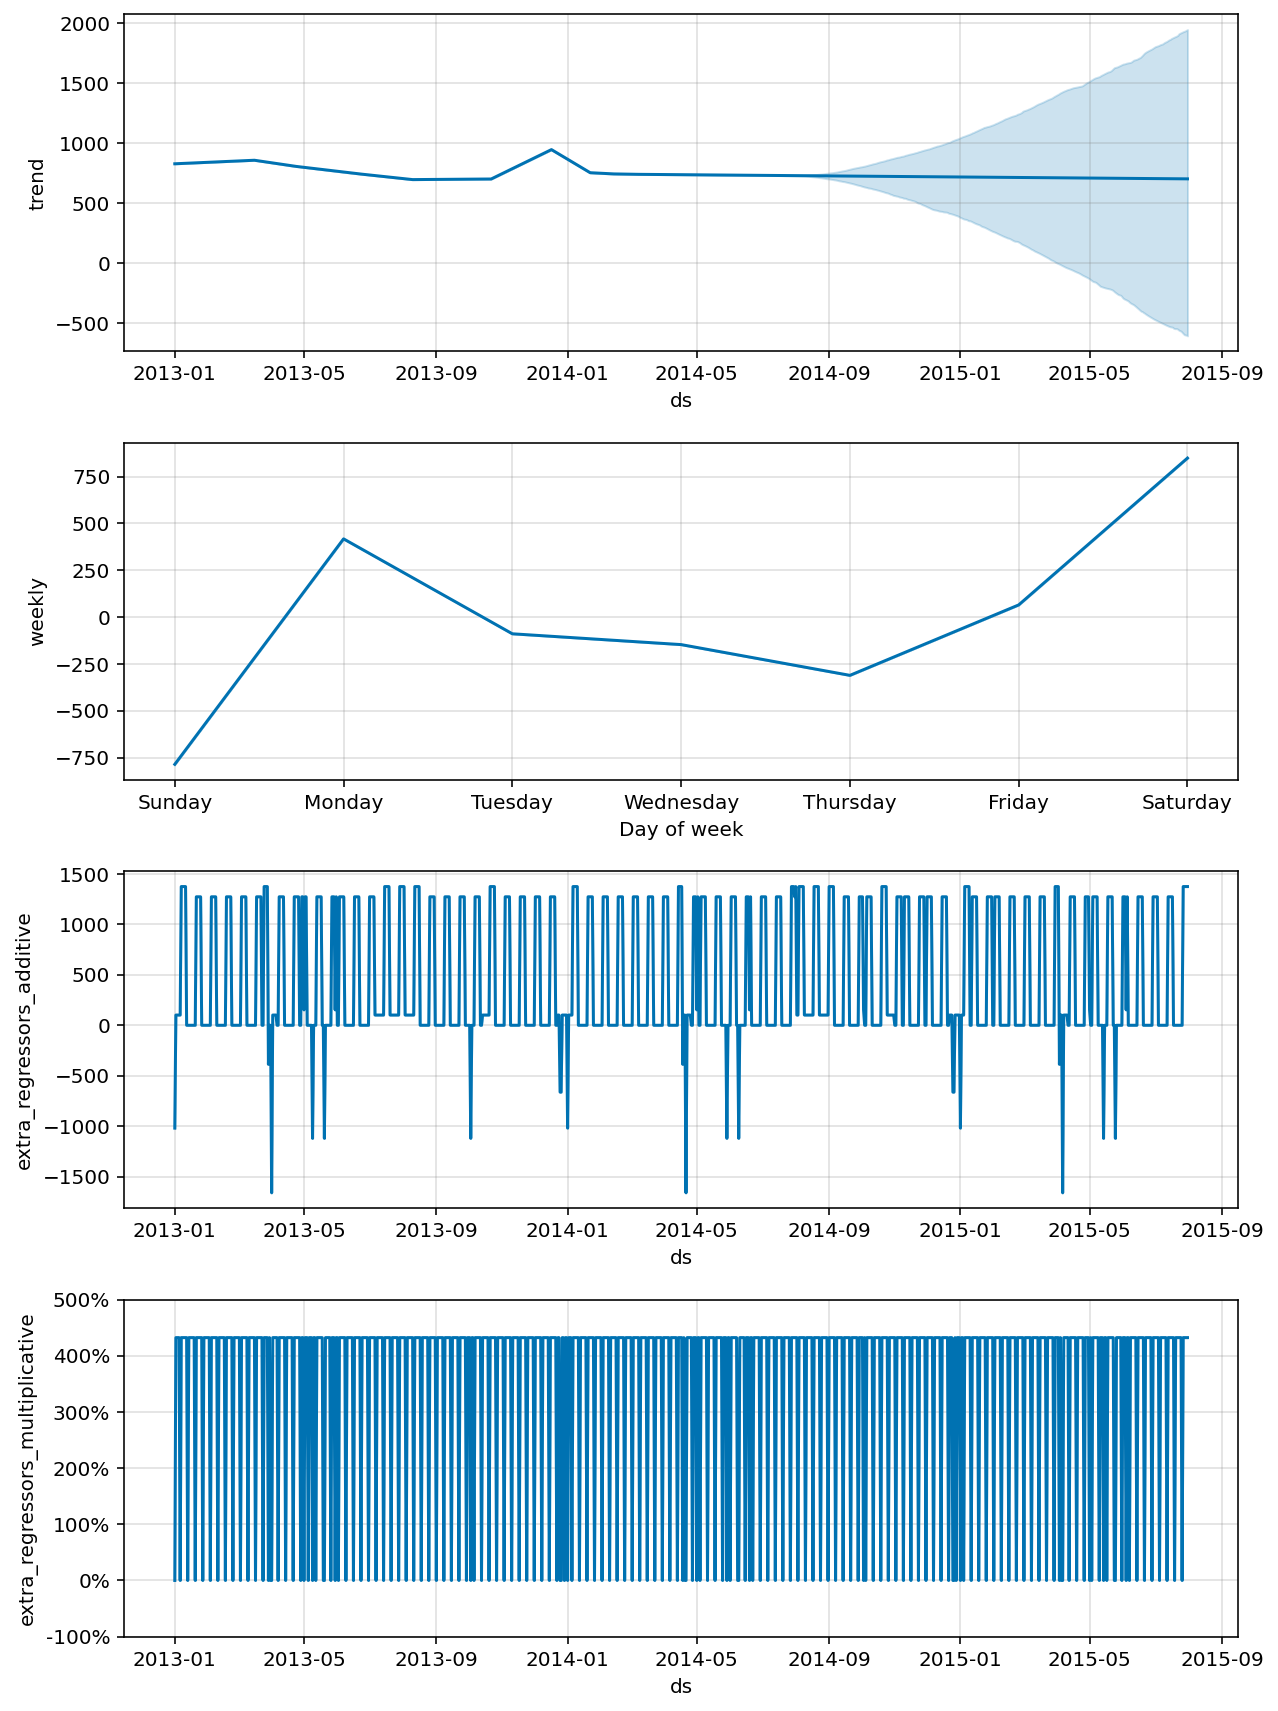

In [30]:
pm4.plot_components()
plt.show()

#### 可能出现的Bug

In [31]:
pm4 = PipelinedModel(full_pipeline, create_model()).fit(sales)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


2013-01-01 00:00:00 2015-07-31 00:00:00


/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -45.6372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       2134.42    0.00655309       127.441           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       2136.83   0.000278971       152.061   8.527e-07       0.001      197  LS failed, Hessian reset 
     199       2140.62     0.0716657       210.237           1           1      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       2143.74    0.00108731       91.6816     0.06073           1      403   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     300       2143.76    0.00276693       136.478   3.018e-05       0.001      448  LS failed, Hessian reset 
     379        2144.7   2.82541e-05       60.8805   3.602e-07       0.001      578  LS failed, Hessian rese

In [32]:
try:
    pm4.plot_components()
except Exception as e:
    print("Got Error: " ,e)

Got Error:  Regressor 'Open' missing from dataframe


**Got an error on future_dataframe, <font color = 'darkcyan'>we don't have feature on out-of-sample period</font>**

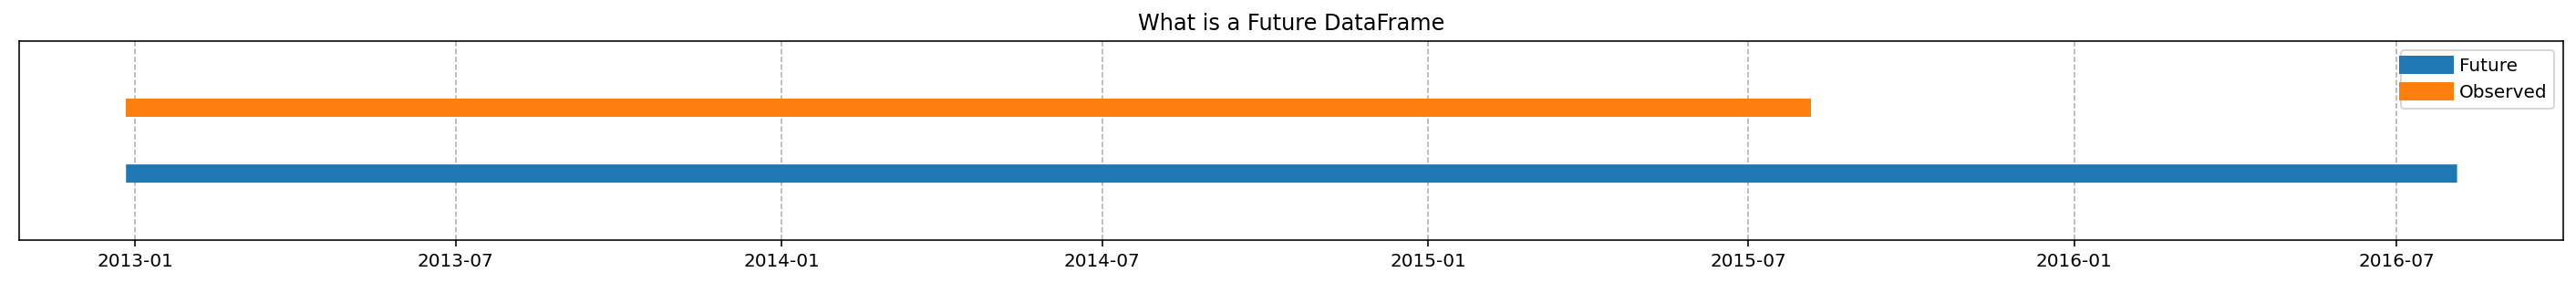

In [33]:
fig, ax = plt.subplots(figsize = (25,2))
plt.plot(future['ds'], np.ones(len(future)), lw = 10, label = 'Future')
plt.plot(
    store1_pipeline(sales)['Date'], 
    2 * np.ones(store1_pipeline(sales).shape[0]), lw = 10, label = 'Observed')

plt.ylim(0,3)
plt.yticks([])
plt.grid(linestyle = '--')
plt.legend(loc = 'upper right')
plt.title("What is a Future DataFrame", fontsize = 12)
plt.show()

### Code Refactor - 自己想办法构建Future

In [34]:
def train_test_split(pipeline, periods = 365):
    df = pipeline(sales).sort_index()
    train = df[:-365]
    test = df[-365:]
    return train, test

full_pipeline = compose(
    store1_pipeline, 
    feature_engineering, 
    feed_to_prophet_multivariable('Date', 'Sales', ['ds','y','Promo','SH1','SH2','SH3','SchoolHoliday',"Open"])
    )

sales_df = full_pipeline(sales)
train,test = train_test_split(full_pipeline)

mm = Prophet()
mm.add_regressor('Open', mode = 'multiplicative')
mm.add_regressor('Promo', mode = 'additive')
mm.add_regressor('SH1', mode = 'additive')
mm.add_regressor('SH2', mode = 'additive')
mm.add_regressor('SH3', mode = 'additive')
mm.add_regressor('SchoolHoliday', mode = 'additive')
_ = mm.fit(train)

forecast = mm.predict(sales_df.drop('y', axis = 1).sort_index())

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Initial log joint probability = -29.6789
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        1255.9     0.0294902       195.013           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       1263.23   0.000965757       122.675           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       1263.88   0.000176304       104.097    1.59e-06       0.001      324  LS failed, Hessian reset 
     299       1264.41    0.00115716       82.2401           1           1      397   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     303        1264.5   0.000721204       119.111   8.458e-06       0.001      441  LS failed, Hessian reset 
     399        1265.1    0.00594722       90.8996           1           1      570   
    Iter      log pro

/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/l

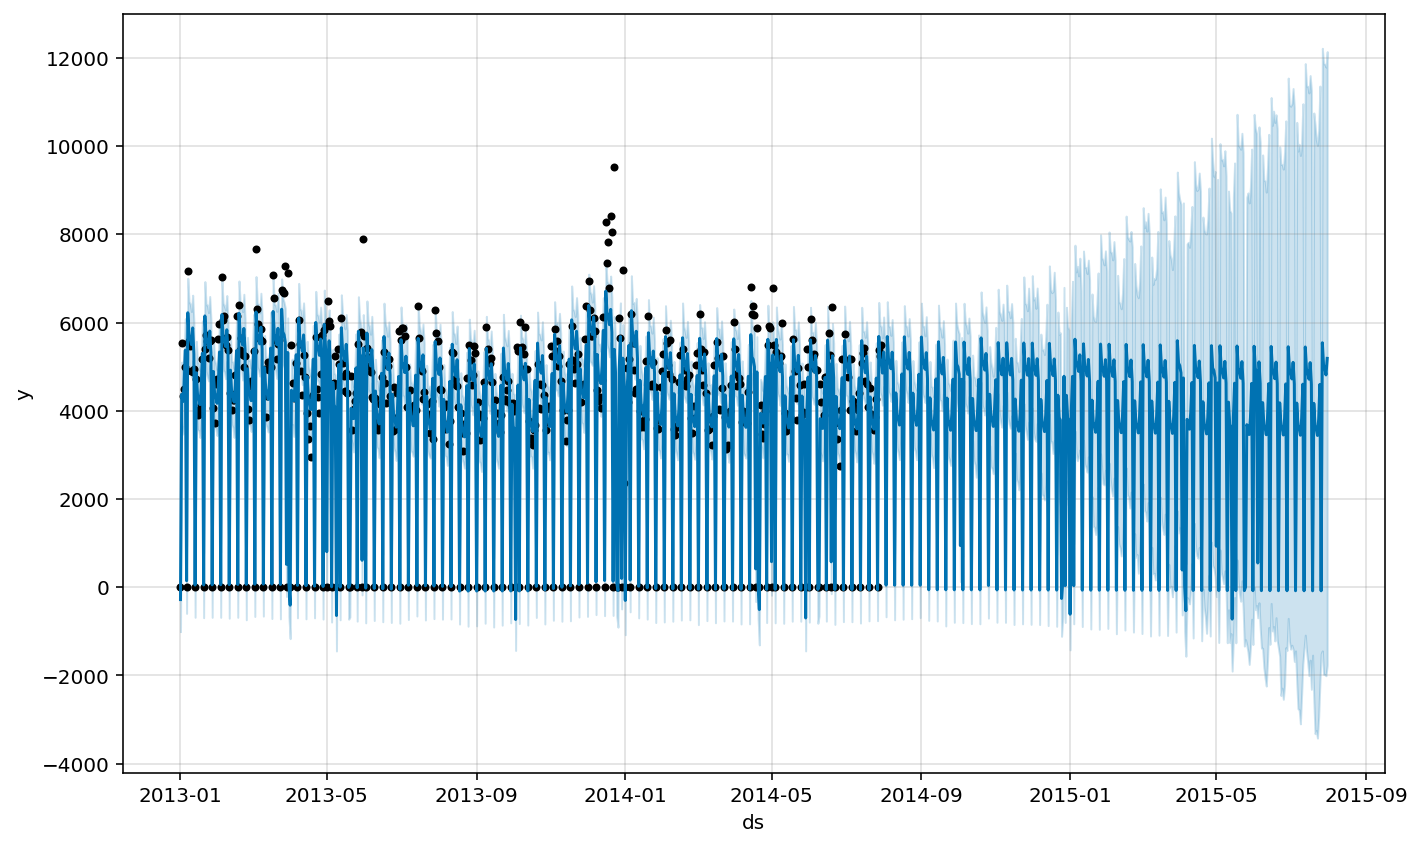

In [35]:
mm.plot(forecast)
plt.show()

/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
/opt/anaconda3/lib/python3.8/site-packages/prophet/forecaster.py:896: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


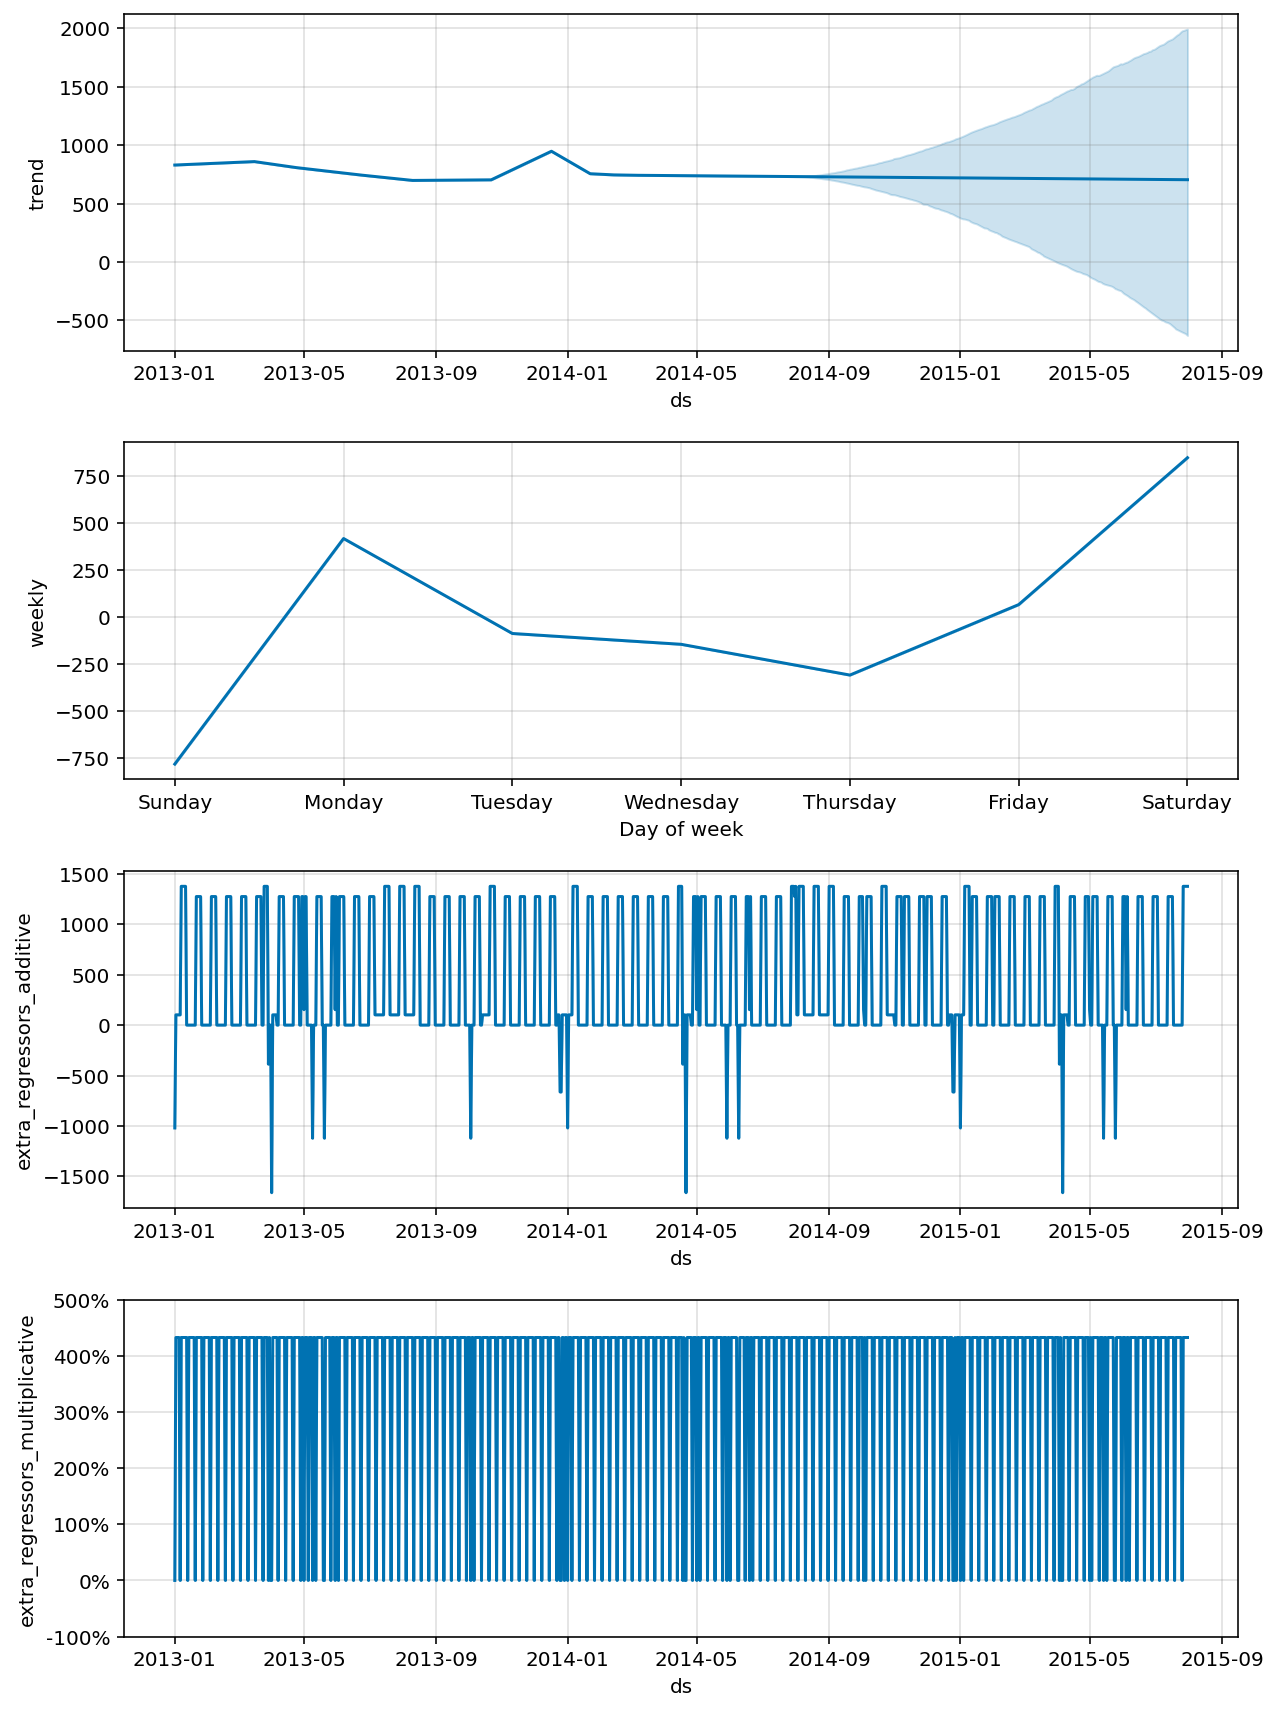

In [36]:
mm.plot_components(forecast)
plt.show()

### Now we have 4 models

In [37]:
pm1.model, pm2.model, pm3.model, pm4.model

(<prophet.forecaster.Prophet at 0x7fd4ba1a7bb0>,
 <prophet.forecaster.Prophet at 0x7fd4bb7bb9d0>)

In [38]:
from prophet.diagnostics import cross_validation

In [39]:
import logging
from IPython.display import clear_output
logging.getLogger('prophet').setLevel(logging.ERROR) 
logging.getLogger('fbprophet').setLevel(logging.ERROR) 

In [40]:
# initial, initial training points
# period step size
# horizon, number of steps to forecast
cv_df = cross_validation(
    pm1.model, 
    initial = "730 days", 
    period = '30 days', 
    horizon = '60 days', 
    disable_tqdm= False)
clear_output()

In [41]:
# cutoff - 从哪一天预测过来的
# ds 预测的是哪一天
# y 观测数据
# yhat 预测数据
# yhat_lower, yhat_upper 预测数据的上下限
cv_df

ds         yhat   yhat_lower   yhat_upper     y     cutoff
0   2015-01-03  4617.439005  3202.608189  6135.973946  5023 2015-01-02
1   2015-01-04  -435.280859 -1959.337923  1132.655136     0 2015-01-02
2   2015-01-05  4582.551056  3156.437034  6070.064003  6239 2015-01-02
3   2015-01-06  4199.481135  2779.345628  5648.372642  4574 2015-01-02
4   2015-01-07  3962.672042  2545.025494  5379.030555  4796 2015-01-02
..         ...          ...          ...          ...   ...        ...
355 2015-07-27  4777.053727  3332.767003  6241.472283  6102 2015-06-01
356 2015-07-28  4452.410348  3029.801815  5958.737724  5011 2015-06-01
357 2015-07-29  4237.801556  2830.559191  5747.538020  4782 2015-06-01
358 2015-07-30  3862.202614  2396.712598  5295.192552  5020 2015-06-01
359 2015-07-31  4254.298993  2847.281124  5764.862850  5263 2015-06-01

[360 rows x 6 columns]

In [42]:
from prophet.diagnostics import performance_metrics


p_metric = performance_metrics(cv_df)
p_metric.head()

horizon           mse         rmse         mae     mdape     smape  coverage
0  6 days  2.221036e+06  1490.314090  916.549666  0.136786  0.549683  0.805556
1  7 days  1.584931e+06  1258.940418  755.834731  0.131188  0.491100  0.833333
2  8 days  1.459901e+06  1208.263829  702.403204  0.122341  0.485572  0.888889
3  9 days  1.167266e+06  1080.401047  687.844823  0.144221  0.453405  0.916667
4 10 days  5.054647e+05   710.960399  576.953174  0.155477  0.460048  0.944444

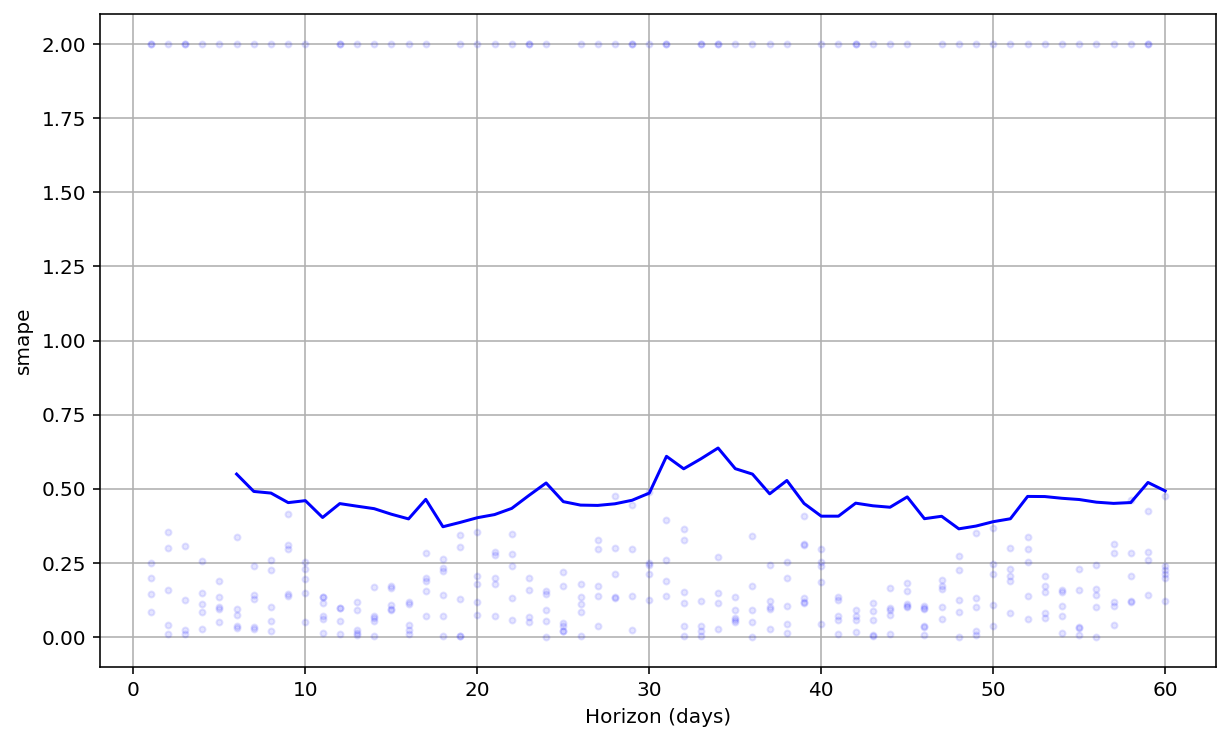

In [43]:
from prophet.plot import plot_cross_validation_metric

plot_cross_validation_metric(cv_df, metric = 'smape')
plt.show()

In [44]:
cross_validation_results = {}
for i, model in enumerate([pm1.model, pm2.model, pm3.model]):
    cross_validation_results[f"model_{i}"] = \
        cross_validation(
            model, 
            initial = "730 days", 
            period = '30 days', 
            horizon = '60 days', 
            disable_tqdm= False
        )
    clear_output()

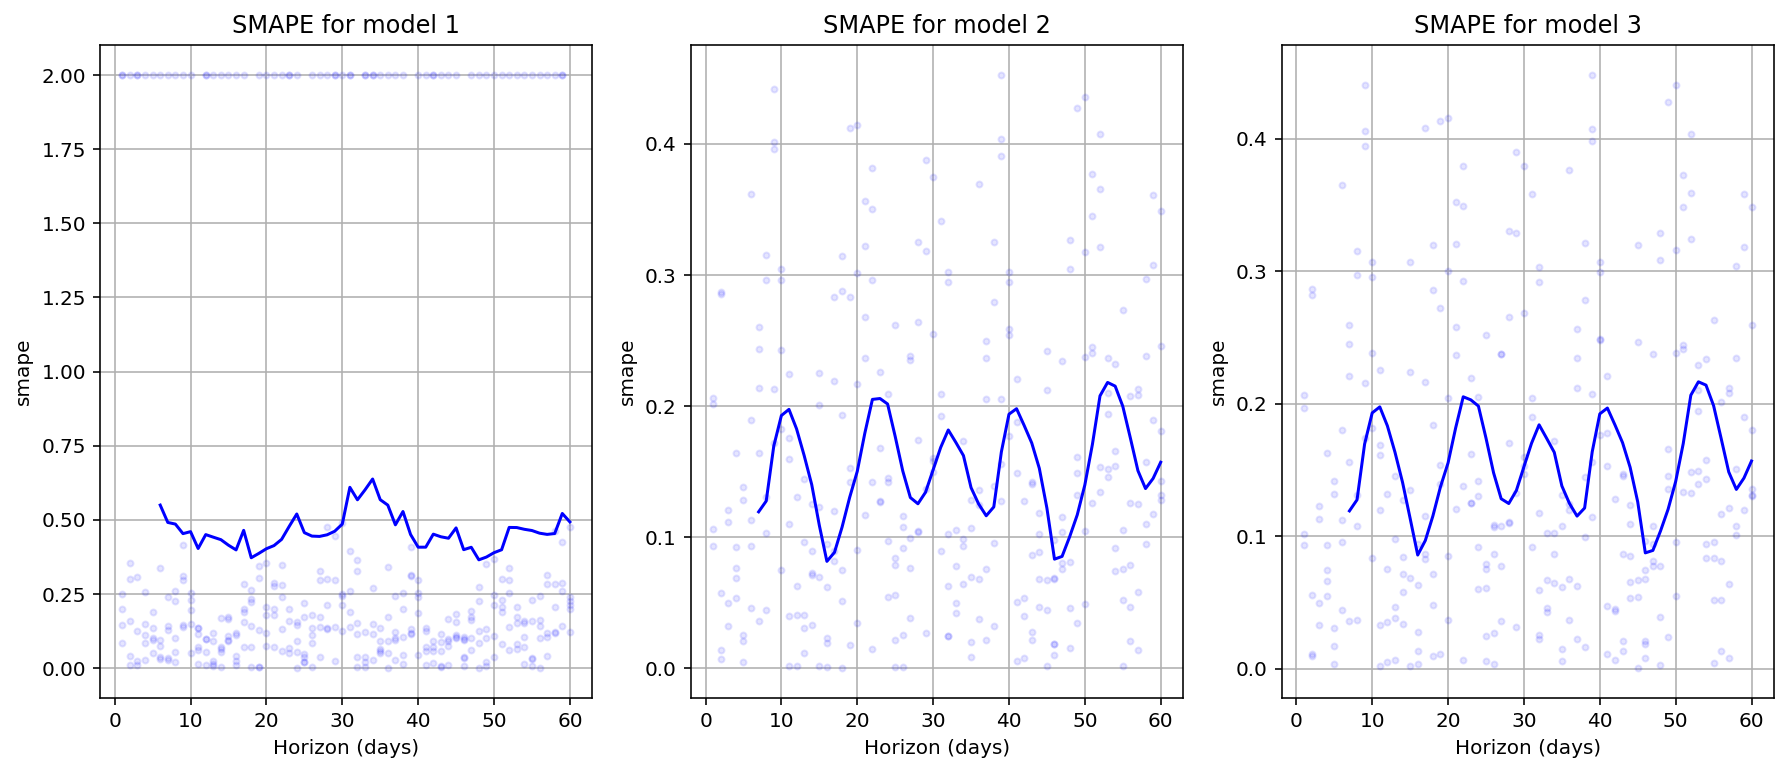

In [45]:
i = 1
fig ,ax = plt.subplots(figsize = (15,6))
for model_name, cdf  in cross_validation_results.items():
    ax = plt.subplot(1, 3, i)
    plot_cross_validation_metric(cdf, metric = 'smape',ax = ax)
    plt.title(f"SMAPE for model {i}")
    i += 1

In [46]:
for model_name, cdf  in cross_validation_results.items():
    p_metric = performance_metrics(cdf)
    print(f"{model_name}:", p_metric['rmse'].mean())

model_0: 1004.8815182570897
model_1: 837.9587051569125
model_2: 851.25232746452


In [47]:
for model_name, cdf  in cross_validation_results.items():
    p_metric = performance_metrics(cdf)
    print(f"{model_name}:", p_metric['smape'].mean())

model_0: 0.4617461459356448
model_1: 0.1537354463863325
model_2: 0.15416697335429352


In [48]:
cvdf_4 = cross_validation(
            model, 
            initial = "500 days", 
            period = '30 days', 
            horizon = '60 days', 
            disable_tqdm= False
        )


p_metric = performance_metrics(cvdf_4)
clear_output()

In [49]:
p_metric['smape'].mean(), p_metric['rmse'].mean()

(0.15480004566531527, 892.1374790379474)

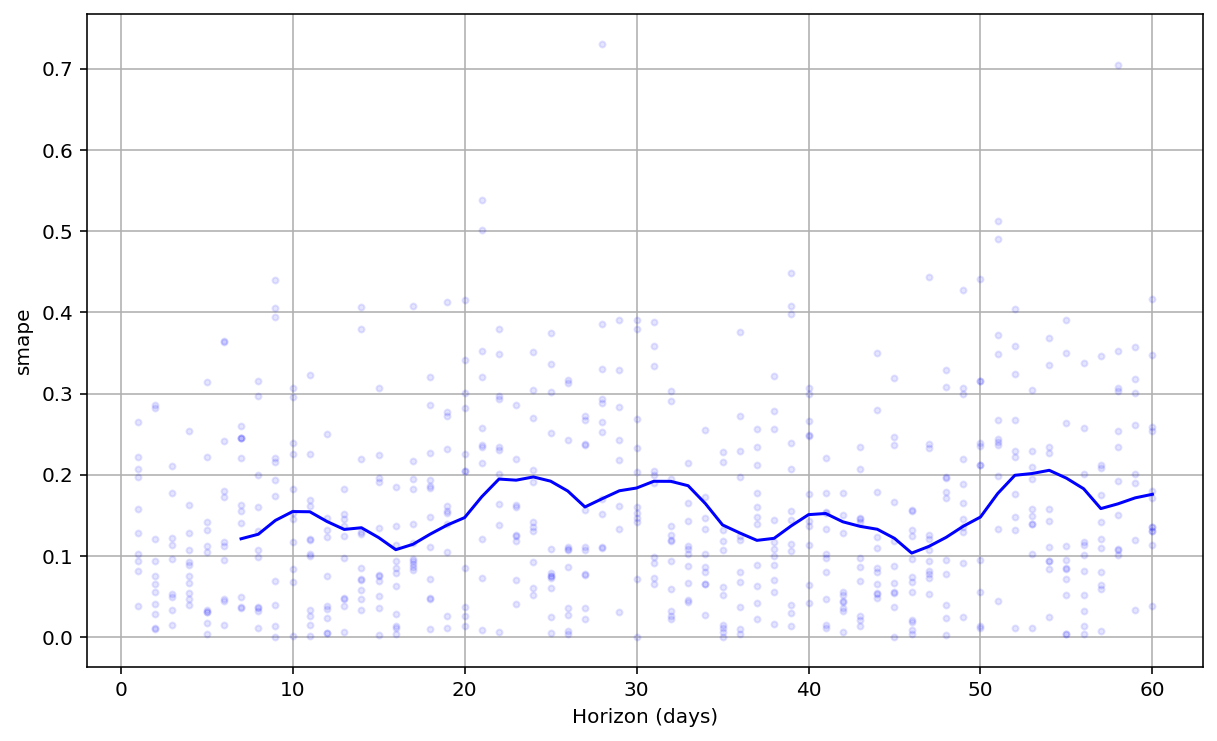

In [50]:
plot_cross_validation_metric(cvdf_4, metric = 'smape')
plt.show()

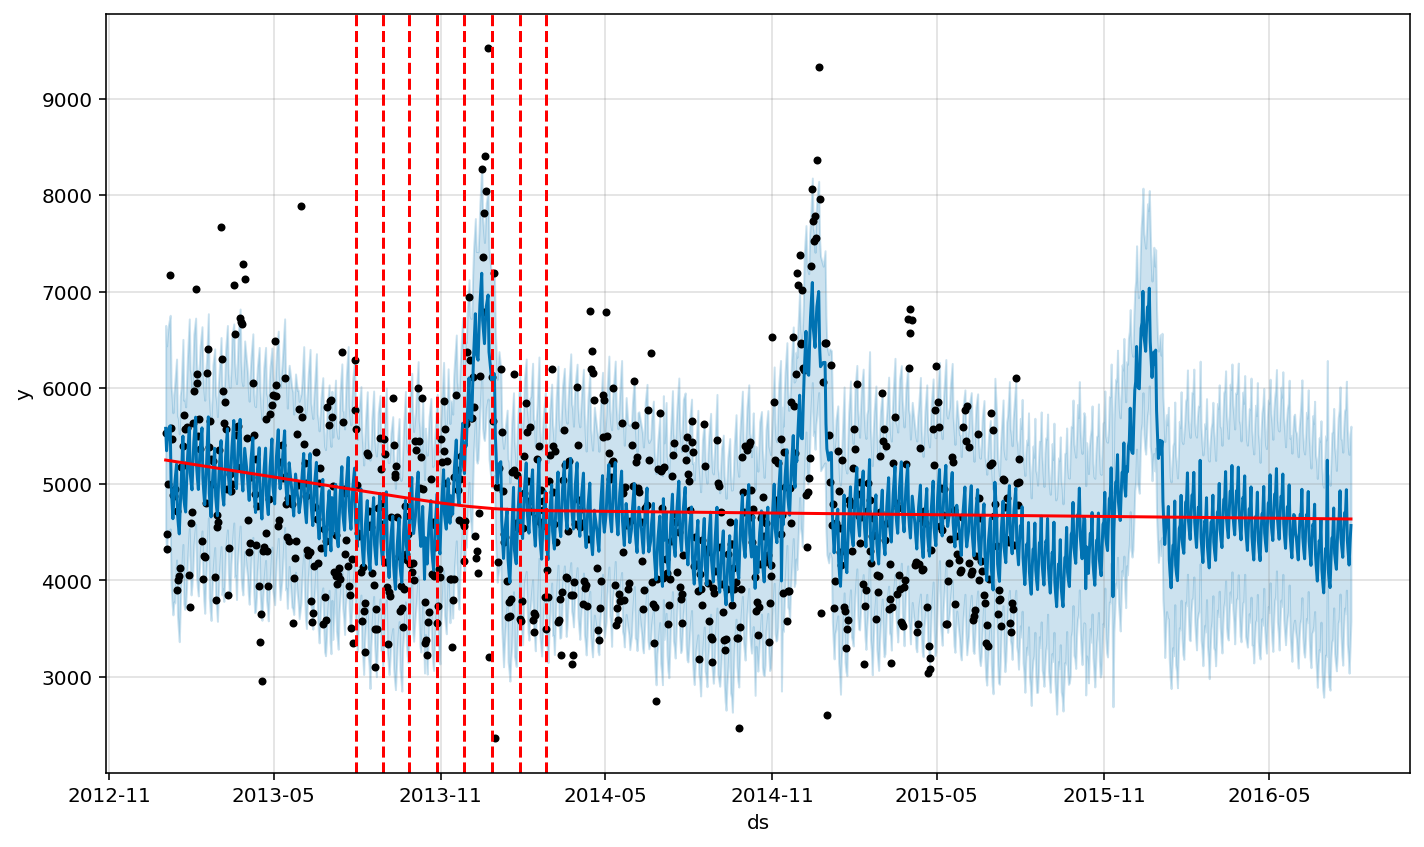

In [62]:
from prophet.plot import add_changepoints_to_plot

fig = pm3.plot()
a = add_changepoints_to_plot(fig.gca(), pm3.model, pm3.forecast(), threshold = 0.001)
clear_output()
plt.show()
